# Outframe Stop Codonの可視化

## purpose
0. compare the absolute number of stop codons on each reading frame
0. compare the pressure on stop codons on each reading frame


## prerequisite
* .gff (parsed by BCBio)
* .fasta x2

In [53]:
from BCBio import GFF
from Bio import SeqIO
import Bio
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## load sequences

In [13]:
rseqFilepath="GCF_000242335.1_ASM24233v3_chromosome.fna"
rseqRec_lst=[]
for seqRec in SeqIO.parse(rseqFilepath, "fasta"):
    rseqRec_lst.append(seqRec)
print("LOADED {0} seqs from {1}".format(len(rseqRec_lst), rseqFilepath))

LOADED 2 seqs from GCF_000242335.1_ASM24233v3_chromosome.fna


In [15]:
sseqFilepath="GCF_000242335.1_ASM24233v3_chromosome_simu03_0.fna"
sseqRec_lst=[]
for seqRec in SeqIO.parse(sseqFilepath, "fasta"):
    sseqRec_lst.append(seqRec)
print("LOADED {0} seqs from {1}".format(len(sseqRec_lst), sseqFilepath))

LOADED 2 seqs from GCF_000242335.1_ASM24233v3_chromosome_simu03_0.fna


## load cds regions

In [12]:
gffFilepath = "GCF_000242335.1_ASM24233v3_genomic.gff"
cds_lst=[]
with open(gffFilepath) as f:
    for rec in GFF.parse(f,target_lines=1):
        assert len(rec.features)==1
        if rec.features[0].type=="CDS":
            cds_lst.append(rec)
print("LOADED {0} CDSs from {1}".format(len(cds_lst), gffFilepath))

LOADED 2564 CDSs


In [31]:
int(cds_lst[0].features[0].location.start)

371

## organize osc information into DataFrame

In [41]:
def get_osc_df(seqRec_lst, cds_lst):
    """ create dataframe of osc (Outframe Stop Codon ) based on .fasta & corresponding cds_lst"""
    
    def find_codons(seq,codons,frame=1):
        """find designated codons on designated reading frame(1~6)"""
        
        assert frame in [1,2,3,4,5,6]
        assert len(seq)%3==0
        
        shift=(frame-1)%3    
        loopCount=int(len(seq)/3)
        if shift>0:
            loopCount-=1
        if frame>=4:
            codons=[Bio.Seq.Seq(codon).reverse_complement() for codon in codons]

        pos_lst=[]
        for i in range(loopCount):
            idx=3*i+shift
            codon=str(seq[idx:idx+3])
            if codon in codons:
                pos_lst.append(idx)
        return pos_lst
    
    

    print("BEGIN processing CDSs")
    dct_lst=[]
    
    count_dct={}
    count_dct["typical"]=0
    count_dct["atypical"]=0
    count_dct["plasmid"]=0
    
    for _, cds in enumerate(cds_lst):
        if _%100==0:
            print("\tProcessing {0}/{1}".format(_+1, len(cds_lst)))
        
        #extract corresponding sequence first
        subSeq=None
        for seqRec in seqRec_lst:
            if cds.id==seqRec.id:
                assert len(cds.features)==1
                subSeq=(cds.features[0].extract(seqRec)).seq
                
        if subSeq is not None:
            if len(subSeq)%3==0 and len(subSeq)>=6: #difinition of  "typical cds"
                count_dct["typical"]+=1
                
                #adds informaion on cds region to dct
                dct={}
                dct["id"]=cds.id
                dct["length"]=len(subSeq)
                dct["start"]=int(cds.features[0].location.start)
                dct["end"]=int(cds.features[0].location.end)
                assert dct["length"]==dct["end"]-dct["start"] 
                
                #adds information on osc for each reading frame
                for frame in range(1,7):
                    pos_lst=find_codons(subSeq, codons=["TAA","TAG","TGA"],frame=frame)
                    relPos_lst=[pos/len(subSeq) for pos in pos_lst]

                    dct["frame{}_num".format(frame)]=int(len(pos_lst))
                    dct["frame{}_per".format(frame)]=len(pos_lst)*3/len(subSeq)
                    dct["frame{}_pos".format(frame)]=":".join([str(pos) for pos in pos_lst])
                    dct["frame{}_rel".format(frame)]=":".join([str(pos) for pos in relPos_lst])
                dct_lst.append(dct)    
            else:
                count_dct["atypical"]+=1
        else:
            print("\tNo corresponding id : {}".format(cds.id))
            count_dct["plasmid"]+=1
    print("DONE extracting osc infromation on  {0}/{1} CDSs (plasmid: {2}, atypical: {3})".format(len(dct_lst), len(cds_lst), count_dct["plasmid"], count_dct["atypical"] ))

    #format dataframe
    df= pd.DataFrame(dct_lst) 
    columns_lst=["id","length", "start", "end"]
    for frame in range(1,7):
        columns_lst.append("frame{}_num".format(frame))
        columns_lst.append("frame{}_per".format(frame))
    for frame in range(1,7):
        columns_lst.append("frame{}_pos".format(frame))
        columns_lst.append("frame{}_rel".format(frame))
    df=df[columns_lst]
    return df

## get real_df

In [42]:
real_df= get_osc_df(rseqRec_lst, cds_lst)
print(real_df.shape)
real_df.head()

BEGIN processing CDSs
	Processing 1/2564
	Processing 101/2564
	Processing 201/2564
	Processing 301/2564
	Processing 401/2564
	Processing 501/2564
	Processing 601/2564
	Processing 701/2564
	Processing 801/2564
	Processing 901/2564
	Processing 1001/2564
	Processing 1101/2564
	Processing 1201/2564
	Processing 1301/2564
	Processing 1401/2564
	Processing 1501/2564
	Processing 1601/2564
	Processing 1701/2564
	Processing 1801/2564
	Processing 1901/2564
	Processing 2001/2564
	Processing 2101/2564
	Processing 2201/2564
	Processing 2301/2564
	Processing 2401/2564
	Processing 2501/2564
	No corresponding id : NC_019961.1
	No corresponding id : NC_019961.1
	No corresponding id : NC_019961.1
	No corresponding id : NC_019961.1
	No corresponding id : NC_019961.1
	No corresponding id : NC_019969.1
	No corresponding id : NC_019969.1
	No corresponding id : NC_019969.1
	No corresponding id : NC_019969.1
DONE extracting osc infromation on  2532/2564 CDSs (plasmid: 9, atypical: 23)
(2532, 28)


,id,length,start,end,frame1_num,frame1_per,frame2_num,frame2_per,frame3_num,frame3_per,...,frame2_pos,frame2_rel,frame3_pos,frame3_rel,frame4_pos,frame4_rel,frame5_pos,frame5_rel,frame6_pos,frame6_rel
0,NC_019960.1,1032,371,1403,1,0.002907,8,0.023256,5,0.014535,...,1:112:211:241:412:448:634:706,0.0009689922480620155:0.10852713178294573:0.20...,14:44:56:230:932,0.013565891472868217:0.04263565891472868:0.054...,678,0.6569767441860465,19:91:220:247:253:301:331:409:454:463:499:529:...,0.018410852713178296:0.08817829457364341:0.213...,179:377:395:548:971:995,0.17344961240310078:0.3653100775193798:0.38275...
1,NC_019960.1,1491,1956,3447,1,0.002012,17,0.034205,0,0.000000,...,10:55:136:367:613:730:796:817:823:829:841:931:...,0.00670690811535882:0.03688799463447351:0.0912...,,,9:15,0.006036217303822937:0.01006036217303823,22:46:67:70:178:274:289:331:397:442:478:490:49...,0.014755197853789403:0.03085177733065057:0.044...,38:74:146:152:182:209:245:338:416:425:500:545:...,0.025486250838363516:0.04963112005365526:0.097...
2,NC_019960.1,1233,3577,4810,1,0.002433,15,0.036496,1,0.002433,...,184:190:232:283:301:415:619:652:913:979:1012:1...,0.1492295214922952:0.154095701540957:0.1881589...,995,0.8069748580697486,,,7:34:151:181:211:244:298:346:355:382:418:433:4...,0.0056772100567721:0.027575020275750203:0.1224...,11:59:89:488:779:839:1034:1100:1115,0.008921330089213302:0.047850770478507706:0.07...
3,NC_019960.1,1254,5269,6523,1,0.002392,14,0.033493,7,0.016746,...,49:79:106:115:226:319:370:391:514:592:664:853:...,0.03907496012759171:0.06299840510366826:0.0845...,212:578:587:689:941:974:1040,0.16905901116427433:0.4609250398724083:0.46810...,225,0.17942583732057416,4:193:208:313:343:418:469:631:652:673:676:700:...,0.003189792663476874:0.15390749601275916:0.165...,182:335:350:353:359:560:584:620:830:875:1025:1...,0.14513556618819776:0.2671451355661882:0.27910...
4,NC_019960.1,4404,6819,11223,1,0.000681,74,0.050409,45,0.030654,...,7:25:73:151:202:214:232:277:355:391:397:430:56...,0.001589464123524069:0.005676657584014532:0.01...,683:776:965:1040:1109:1457:1466:1601:1622:1688...,0.155086285195277:0.17620345140781107:0.219118...,48:510:957:960:3978:4146,0.010899182561307902:0.11580381471389646:0.217...,94:157:220:247:265:340:370:490:622:640:643:703...,0.02134423251589464:0.03564940962761126:0.0499...,113:260:269:380:452:485:593:650:671:680:737:89...,0.025658492279745686:0.05903723887375113:0.061...


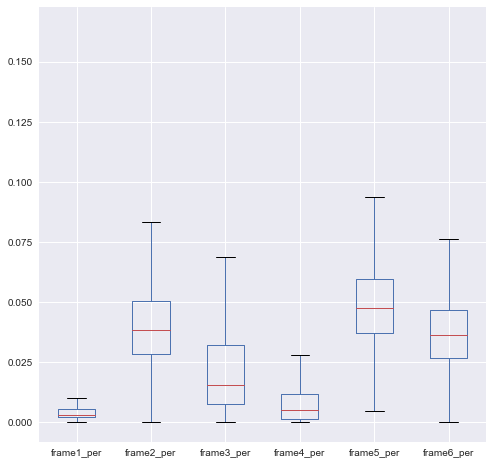

In [43]:
plt.figure(figsize=(8,8))
real_df.boxplot(column=["frame1_per","frame2_per","frame3_per","frame4_per","frame5_per","frame6_per"])
plt.show()

## get sim_df

In [44]:
sim_df= get_osc_df(sseqRec_lst, cds_lst)
print(sim_df.shape)
sim_df.head()

BEGIN processing CDSs
	Processing 1/2564
	Processing 101/2564
	Processing 201/2564
	Processing 301/2564
	Processing 401/2564
	Processing 501/2564
	Processing 601/2564
	Processing 701/2564
	Processing 801/2564
	Processing 901/2564
	Processing 1001/2564
	Processing 1101/2564
	Processing 1201/2564
	Processing 1301/2564
	Processing 1401/2564
	Processing 1501/2564
	Processing 1601/2564
	Processing 1701/2564
	Processing 1801/2564
	Processing 1901/2564
	Processing 2001/2564
	Processing 2101/2564
	Processing 2201/2564
	Processing 2301/2564
	Processing 2401/2564
	Processing 2501/2564
	No corresponding id : NC_019961.1
	No corresponding id : NC_019961.1
	No corresponding id : NC_019961.1
	No corresponding id : NC_019961.1
	No corresponding id : NC_019961.1
	No corresponding id : NC_019969.1
	No corresponding id : NC_019969.1
	No corresponding id : NC_019969.1
	No corresponding id : NC_019969.1
DONE extracting osc infromation on  2532/2564 CDSs (plasmid: 9, atypical: 23)
(2532, 28)


,id,length,start,end,frame1_num,frame1_per,frame2_num,frame2_per,frame3_num,frame3_per,...,frame2_pos,frame2_rel,frame3_pos,frame3_rel,frame4_pos,frame4_rel,frame5_pos,frame5_rel,frame6_pos,frame6_rel
0,NC_019960.1,1032,371,1403,1,0.002907,15,0.043605,17,0.049419,...,1:34:211:220:301:403:412:454:541:598:706:724:8...,0.0009689922480620155:0.03294573643410853:0.20...,14:56:92:113:143:419:488:551:611:641:683:713:7...,0.013565891472868217:0.05426356589147287:0.089...,177:510:540:1020,0.17151162790697674:0.4941860465116279:0.52325...,91:142:247:253:331:409:463:499:529:574:760:808...,0.08817829457364341:0.1375968992248062:0.23934...,98:167:353:395:548:971,0.09496124031007752:0.1618217054263566:0.34205...
1,NC_019960.1,1491,1956,3447,1,0.002012,29,0.058350,11,0.022133,...,10:22:46:70:136:178:268:442:478:529:571:595:63...,0.00670690811535882:0.014755197853789403:0.030...,206:215:344:428:548:566:632:893:1085:1394:1439,0.1381623071763917:0.1441985244802146:0.230717...,594:1140,0.3983903420523139:0.7645875251509054,67:205:214:274:289:331:367:397:490:496:508:559...,0.04493628437290409:0.1374916163648558:0.14352...,38:74:146:152:338:416:425:584:650:689:767:803:...,0.025486250838363516:0.04963112005365526:0.097...
2,NC_019960.1,1233,3577,4810,1,0.002433,22,0.053528,6,0.014599,...,34:37:151:184:211:301:355:382:415:448:652:718:...,0.027575020275750203:0.030008110300081103:0.12...,113:392:434:590:947:1088,0.09164639091646391:0.31792376317923765:0.3519...,120:381:762:909:996:1011,0.09732360097323602:0.30900243309002434:0.6180...,7:106:181:244:283:298:346:361:412:418:433:454:...,0.0056772100567721:0.08596918085969181:0.14679...,11:89:488:1100:1229,0.008921330089213302:0.07218167072181671:0.395...
3,NC_019960.1,1254,5269,6523,1,0.002392,22,0.052632,22,0.052632,...,4:49:79:106:121:199:274:319:370:430:514:523:59...,0.003189792663476874:0.03907496012759171:0.062...,59:134:248:308:344:365:392:419:458:497:635:656...,0.04704944178628389:0.10685805422647528:0.1977...,429:702:864,0.34210526315789475:0.5598086124401914:0.68899...,58:115:130:193:208:226:313:343:391:418:469:631...,0.046251993620414676:0.09170653907496013:0.103...,182:302:353:494:560:584:620:791:830:1025:1247:...,0.14513556618819776:0.24082934609250398:0.2814...
4,NC_019960.1,4404,6819,11223,1,0.000681,57,0.038828,53,0.036104,...,25:94:151:157:232:355:391:430:445:508:556:589:...,0.005676657584014532:0.02134423251589464:0.034...,11:86:131:134:194:314:323:404:467:605:776:932:...,0.002497729336966394:0.01952770208900999:0.029...,15:387:960:1098:1980:2352:2598:3213:3243:3387:...,0.0034059945504087193:0.08787465940054497:0.21...,10:70:130:139:214:220:247:265:340:370:490:514:...,0.002270663033605813:0.01589464123524069:0.029...,161:260:269:452:482:485:593:680:734:737:926:99...,0.036557674841053586:0.05903723887375113:0.061...


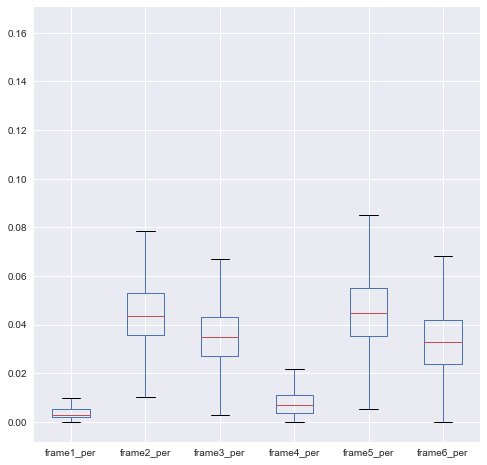

In [45]:
plt.figure(figsize=(8,8))
sim_df.boxplot(column=["frame1_per","frame2_per","frame3_per","frame4_per","frame5_per","frame6_per"])
plt.show()

## concat real_df & sim_df into df

In [68]:
#df=pd.concat([real_df,sim_df],axis=1, keys=["real", "sim"])
df=pd.merge(real_df, sim_df, on=["id","length","start","end"], suffixes=["_real", "_sim"])
print(df.shape)
df.head()

(2532, 52)


,id,length,start,end,frame1_num_real,frame1_per_real,frame2_num_real,frame2_per_real,frame3_num_real,frame3_per_real,...,frame2_pos_sim,frame2_rel_sim,frame3_pos_sim,frame3_rel_sim,frame4_pos_sim,frame4_rel_sim,frame5_pos_sim,frame5_rel_sim,frame6_pos_sim,frame6_rel_sim
0,NC_019960.1,1032,371,1403,1,0.002907,8,0.023256,5,0.014535,...,1:34:211:220:301:403:412:454:541:598:706:724:8...,0.0009689922480620155:0.03294573643410853:0.20...,14:56:92:113:143:419:488:551:611:641:683:713:7...,0.013565891472868217:0.05426356589147287:0.089...,177:510:540:1020,0.17151162790697674:0.4941860465116279:0.52325...,91:142:247:253:331:409:463:499:529:574:760:808...,0.08817829457364341:0.1375968992248062:0.23934...,98:167:353:395:548:971,0.09496124031007752:0.1618217054263566:0.34205...
1,NC_019960.1,1491,1956,3447,1,0.002012,17,0.034205,0,0.000000,...,10:22:46:70:136:178:268:442:478:529:571:595:63...,0.00670690811535882:0.014755197853789403:0.030...,206:215:344:428:548:566:632:893:1085:1394:1439,0.1381623071763917:0.1441985244802146:0.230717...,594:1140,0.3983903420523139:0.7645875251509054,67:205:214:274:289:331:367:397:490:496:508:559...,0.04493628437290409:0.1374916163648558:0.14352...,38:74:146:152:338:416:425:584:650:689:767:803:...,0.025486250838363516:0.04963112005365526:0.097...
2,NC_019960.1,1233,3577,4810,1,0.002433,15,0.036496,1,0.002433,...,34:37:151:184:211:301:355:382:415:448:652:718:...,0.027575020275750203:0.030008110300081103:0.12...,113:392:434:590:947:1088,0.09164639091646391:0.31792376317923765:0.3519...,120:381:762:909:996:1011,0.09732360097323602:0.30900243309002434:0.6180...,7:106:181:244:283:298:346:361:412:418:433:454:...,0.0056772100567721:0.08596918085969181:0.14679...,11:89:488:1100:1229,0.008921330089213302:0.07218167072181671:0.395...
3,NC_019960.1,1254,5269,6523,1,0.002392,14,0.033493,7,0.016746,...,4:49:79:106:121:199:274:319:370:430:514:523:59...,0.003189792663476874:0.03907496012759171:0.062...,59:134:248:308:344:365:392:419:458:497:635:656...,0.04704944178628389:0.10685805422647528:0.1977...,429:702:864,0.34210526315789475:0.5598086124401914:0.68899...,58:115:130:193:208:226:313:343:391:418:469:631...,0.046251993620414676:0.09170653907496013:0.103...,182:302:353:494:560:584:620:791:830:1025:1247:...,0.14513556618819776:0.24082934609250398:0.2814...
4,NC_019960.1,4404,6819,11223,1,0.000681,74,0.050409,45,0.030654,...,25:94:151:157:232:355:391:430:445:508:556:589:...,0.005676657584014532:0.02134423251589464:0.034...,11:86:131:134:194:314:323:404:467:605:776:932:...,0.002497729336966394:0.01952770208900999:0.029...,15:387:960:1098:1980:2352:2598:3213:3243:3387:...,0.0034059945504087193:0.08787465940054497:0.21...,10:70:130:139:214:220:247:265:340:370:490:514:...,0.002270663033605813:0.01589464123524069:0.029...,161:260:269:452:482:485:593:680:734:737:926:99...,0.036557674841053586:0.05903723887375113:0.061...


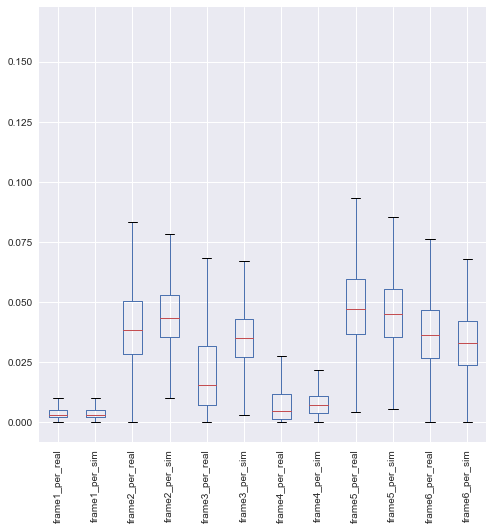

In [55]:
columns_lst=[]
for frame in range(1,7):
    #columns_lst.append(("real", "frame{}_per".format(frame)))
    #columns_lst.append(("sim", "frame{}_per".format(frame)))
    columns_lst.append("frame{0}_per_{1}".format(frame,"real"))
    columns_lst.append("frame{0}_per_{1}".format(frame, "sim"))

plt.figure(figsize=(8,8))
df.boxplot(column=columns_lst)
plt.xticks(rotation=90)
plt.show()

## calcurate osc pressure for each reading frame

In [91]:
for frame in range(1,7):
    realClm="frame{}_num_real".format(frame)
    simClm="frame{}_num_sim".format(frame)
    outClm="frame{}_pres".format(frame)
    df[outClm]=(df[realClm]+1)/(df[simClm]+1)
df.head()

,id,length,start,end,frame1_num_real,frame1_per_real,frame2_num_real,frame2_per_real,frame3_num_real,frame3_per_real,...,frame6_pos_sim,frame6_rel_sim,frame1_pres,frame2_pres,frame3_pres,frame4_pres,frame5_pres,frame6_pres,chrom_length,gene_pos
0,NC_019960.1,1032,371,1403,1,0.002907,8,0.023256,5,0.014535,...,98:167:353:395:548:971,0.09496124031007752:0.1618217054263566:0.34205...,1.0,0.562500,0.333333,0.400000,1.388889,1.000000,1890695,0.000469
1,NC_019960.1,1491,1956,3447,1,0.002012,17,0.034205,0,0.000000,...,38:74:146:152:338:416:425:584:650:689:767:803:...,0.025486250838363516:0.04963112005365526:0.097...,1.0,0.600000,0.083333,1.000000,1.088235,1.269231,1890695,0.001429
2,NC_019960.1,1233,3577,4810,1,0.002433,15,0.036496,1,0.002433,...,11:89:488:1100:1229,0.008921330089213302:0.07218167072181671:0.395...,1.0,0.695652,0.285714,0.142857,1.066667,1.666667,1890695,0.002218
3,NC_019960.1,1254,5269,6523,1,0.002392,14,0.033493,7,0.016746,...,182:302:353:494:560:584:620:791:830:1025:1247:...,0.14513556618819776:0.24082934609250398:0.2814...,1.0,0.652174,0.347826,0.500000,1.120000,1.076923,1890695,0.003118
4,NC_019960.1,4404,6819,11223,1,0.000681,74,0.050409,45,0.030654,...,161:260:269:452:482:485:593:680:734:737:926:99...,0.036557674841053586:0.05903723887375113:0.061...,1.0,1.293103,0.851852,0.500000,0.896552,1.193548,1890695,0.004771


## visualize pressure

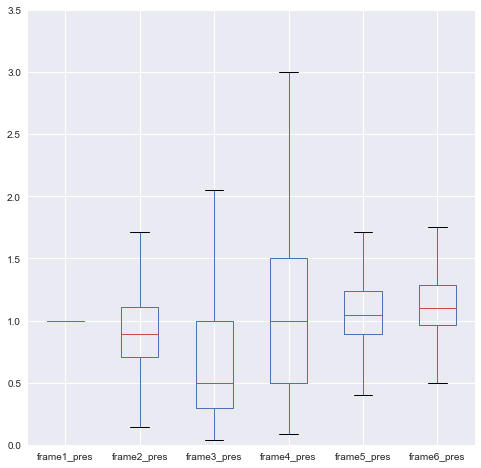

In [93]:
plt.figure(figsize=(8,8))
df.boxplot(column=["frame1_pres","frame2_pres","frame3_pres","frame4_pres","frame5_pres","frame6_pres"])
plt.ylim((0,3.5))
plt.show()

## visualize relation of pressure and position on chromosome

In [94]:
dct_lst=[]
for seqRec in rseqRec_lst:
    dct={}
    dct["id"]=seqRec.id
    dct["chrom_length"]=len(seqRec)
    dct_lst.append(dct)
seq_df=pd.DataFrame(dct_lst)
seq_df=seq_df[["id", "chrom_length"]]
seq_df

,id,chrom_length
0,NC_019960.1,1890695
1,NC_019968.1,1450390


In [95]:
df=pd.merge(df, seq_df, on=["id"], how="left")
df["gene_pos"]=(df["start"]+df["end"])/2/df["chrom_length"]
df.head()

,id,length,start,end,frame1_num_real,frame1_per_real,frame2_num_real,frame2_per_real,frame3_num_real,frame3_per_real,...,frame6_pos_sim,frame6_rel_sim,frame1_pres,frame2_pres,frame3_pres,frame4_pres,frame5_pres,frame6_pres,chrom_length,gene_pos
0,NC_019960.1,1032,371,1403,1,0.002907,8,0.023256,5,0.014535,...,98:167:353:395:548:971,0.09496124031007752:0.1618217054263566:0.34205...,1.0,0.562500,0.333333,0.400000,1.388889,1.000000,1890695,0.000469
1,NC_019960.1,1491,1956,3447,1,0.002012,17,0.034205,0,0.000000,...,38:74:146:152:338:416:425:584:650:689:767:803:...,0.025486250838363516:0.04963112005365526:0.097...,1.0,0.600000,0.083333,1.000000,1.088235,1.269231,1890695,0.001429
2,NC_019960.1,1233,3577,4810,1,0.002433,15,0.036496,1,0.002433,...,11:89:488:1100:1229,0.008921330089213302:0.07218167072181671:0.395...,1.0,0.695652,0.285714,0.142857,1.066667,1.666667,1890695,0.002218
3,NC_019960.1,1254,5269,6523,1,0.002392,14,0.033493,7,0.016746,...,182:302:353:494:560:584:620:791:830:1025:1247:...,0.14513556618819776:0.24082934609250398:0.2814...,1.0,0.652174,0.347826,0.500000,1.120000,1.076923,1890695,0.003118
4,NC_019960.1,4404,6819,11223,1,0.000681,74,0.050409,45,0.030654,...,161:260:269:452:482:485:593:680:734:737:926:99...,0.036557674841053586:0.05903723887375113:0.061...,1.0,1.293103,0.851852,0.500000,0.896552,1.193548,1890695,0.004771


NC_019960.1


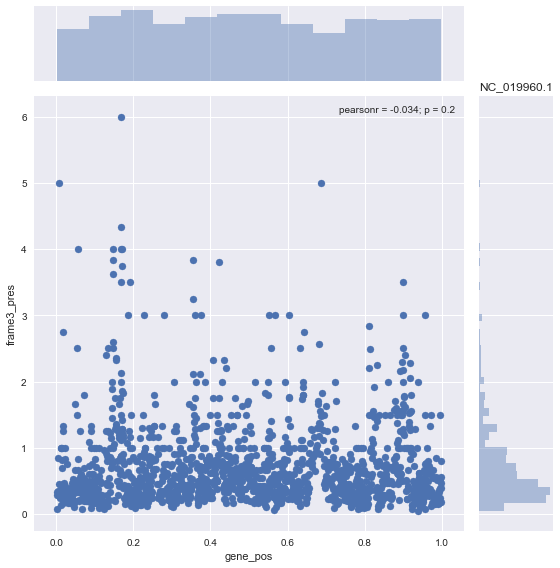

NC_019968.1


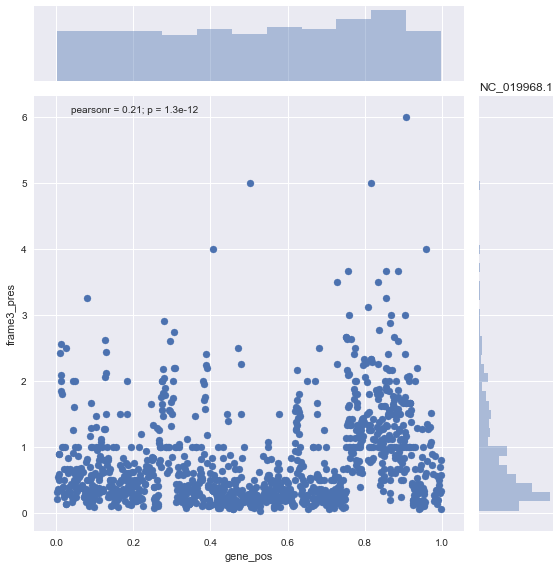

In [96]:
for chromId in set(df["id"]):
    print(chromId)
    sns.jointplot("gene_pos","frame3_pres",data=df[df["id"]==chromId], size=8)
    #sns.jointplot("gene_pos","length",data=df[df["id"]==chromId], size=8)
    plt.title(chromId)
    plt.show()

ところどころpressureの値が高い（=pressureが低い, 混乱を招く、変数名の変更必要）領域が散見される

In [67]:
df.head()

,id,length,start,end,frame1_num_real,frame1_per_real,frame2_num_real,frame2_per_real,frame3_num_real,frame3_per_real,...,frame6_rel_sim,frame1_pres,frame2_pres,frame3_pres,frame4_pres,frame5_pres,frame6_pres,chrom_length_x,gene_pos,chrom_length_y
0,NC_019960.1,1032,371,1403,1,0.002907,8,0.023256,5,0.014535,...,0.09496124031007752:0.1618217054263566:0.34205...,1.0,0.562500,0.333333,0.400000,1.388889,1.000000,1890695,0.000938,1890695
1,NC_019960.1,1491,1956,3447,1,0.002012,17,0.034205,0,0.000000,...,0.025486250838363516:0.04963112005365526:0.097...,1.0,0.600000,0.083333,1.000000,1.088235,1.269231,1890695,0.002858,1890695
2,NC_019960.1,1233,3577,4810,1,0.002433,15,0.036496,1,0.002433,...,0.008921330089213302:0.07218167072181671:0.395...,1.0,0.695652,0.285714,0.142857,1.066667,1.666667,1890695,0.004436,1890695
3,NC_019960.1,1254,5269,6523,1,0.002392,14,0.033493,7,0.016746,...,0.14513556618819776:0.24082934609250398:0.2814...,1.0,0.652174,0.347826,0.500000,1.120000,1.076923,1890695,0.006237,1890695
4,NC_019960.1,4404,6819,11223,1,0.000681,74,0.050409,45,0.030654,...,0.036557674841053586:0.05903723887375113:0.061...,1.0,1.293103,0.851852,0.500000,0.896552,1.193548,1890695,0.009543,1890695


In [18]:
cds_lst[0].features

[SeqFeature(FeatureLocation(ExactPosition(371), ExactPosition(1403), strand=1), type='CDS', id='cds0')]

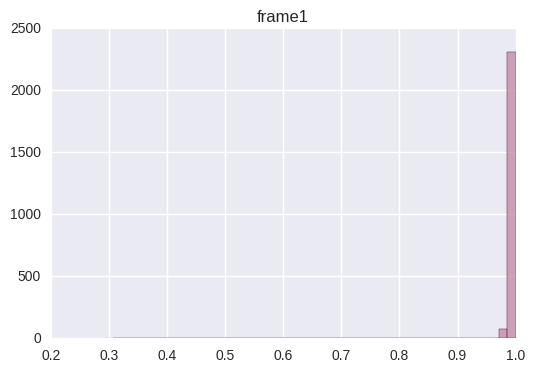

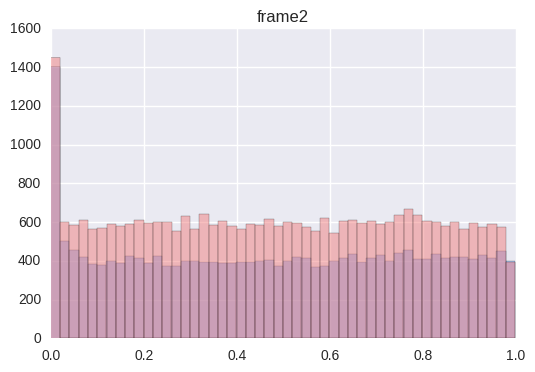

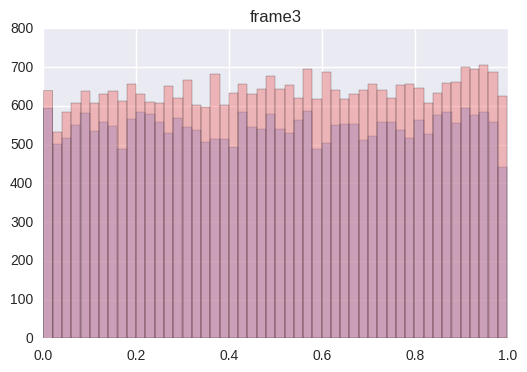

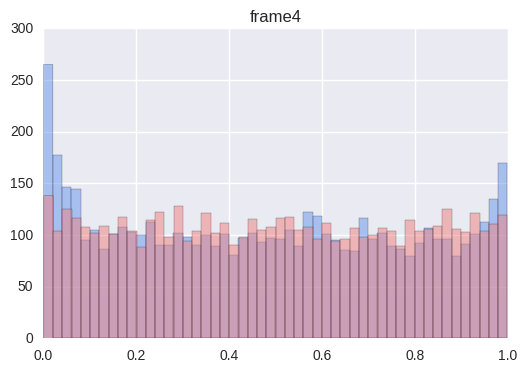

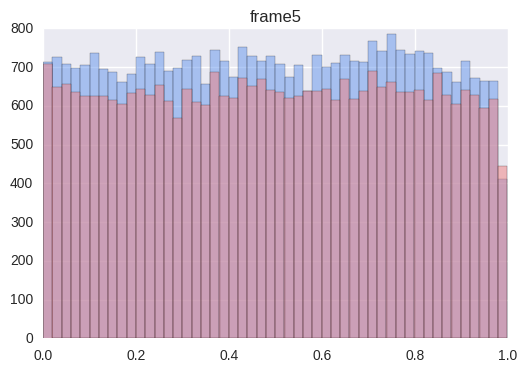

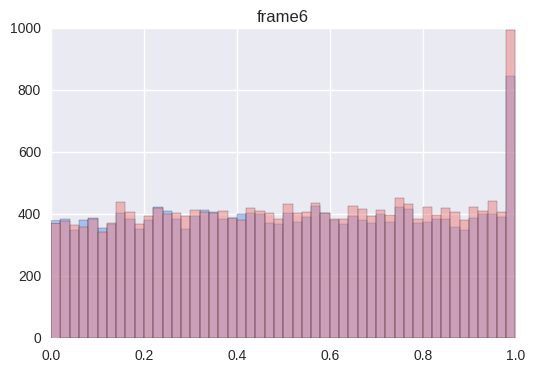

In [83]:
for frame in range(1,7):
    color_lst=["#6495ED","#F08080"]
    for i,df in enumerate((real_df,sim_df)):
        total_lst=[]
        for lst in df["frame{}_rel".format(frame)].dropna():
            if len(lst)>0:
                total_lst+=[float(pos) for pos in lst.split(",")]
        sns.distplot(total_lst, kde=False, rug=False, bins=50,hist_kws={"color":color_lst[i], "alpha":.5})
        plt.title("frame{}".format(frame))
    plt.show()

In [73]:
sim_df.head()

,frame1,frame1_rel,frame2,frame2_rel,frame3,frame3_rel,frame4,frame4_rel,frame5,frame5_rel,frame6,frame6_rel,length
0,222,0.9866666666666667,"1,73,91,205","0.0044444444444444444,0.3244444444444444,0.404...",95,0.4222222222222222,,,"70,94,103,151","0.3111111111111111,0.4177777777777778,0.457777...",77,0.3422222222222222,225
1,1503,0.99800796812749,"1,52,82,91,370,547,598,616,724,988,1045,1069,1...","0.0006640106241699867,0.034528552456839307,0.0...","131,155,191,254,287,329,353,383,440,458,527,56...","0.08698539176626827,0.10292164674634795,0.1268...","105,420,450,954,1326","0.0697211155378486,0.2788844621513944,0.298804...","130,439,481,505,586,628,685,715,721,823,859,94...","0.08632138114209828,0.2915006640106242,0.31938...","146,164,410,470,734,773,797,842,884,923,992,10...","0.09694555112881806,0.10889774236387782,0.2722...",1506
2,324,0.9908256880733946,133,0.40672782874617736,"77,86,128,146","0.23547400611620795,0.26299694189602446,0.3914...",249,0.7614678899082569,"22,52,76,85,145,235","0.0672782874617737,0.15902140672782875,0.23241...","140,158,203,218,272","0.42813455657492355,0.4831804281345566,0.62079...",327
3,1371,0.9978165938864629,"481,520,664,670,772,826,931,1000,1078,1132,128...","0.3500727802037846,0.3784570596797671,0.483260...","5,20,32,200,227,356,422,641,785,818,839,911,10...","0.00363901018922853,0.01455604075691412,0.0232...","306,969,1200","0.22270742358078602,0.7052401746724891,0.87336...","4,73,187,346,379,490,805,862,904,994,1024,1039...","0.002911208151382824,0.05312954876273653,0.136...","596,623,752,1013,1043,1235,1271","0.43377001455604075,0.4534206695778748,0.54730...",1374
4,1152,0.9974025974025974,"1,13,58,130,133,196,295,478,517,541,592,619,65...","0.0008658008658008658,0.011255411255411256,0.0...","44,104,224,269,284,317,338,356,443,647,698,707...","0.0380952380952381,0.09004329004329005,0.19393...","330,438","0.2857142857142857,0.37922077922077924","7,28,43,103,157,355,382,460,547,658,706,751,83...","0.006060606060606061,0.024242424242424242,0.03...","80,170,206,314,524,527,611,728,740,1088,1133","0.06926406926406926,0.1471861471861472,0.17835...",1155


In [16]:
dct_lst=[]
for subSeq in subSeq_lst:
    dct={}
    dct["length"]=len(subSeq)
    if len(subSeq)%3==0 and len(subSeq)>6:
        for frame in range(1,7):
            pos_lst=find_codons(subSeq, codons=["TAA","TAG","TGA"],frame=frame)
            relPos_lst=[pos/len(subSeq) for pos in pos_lst]
            
            dct["frame{}".format(frame)]=",".join([str(pos) for pos in pos_lst])
            dct["frame{}_rel".format(frame)]=",".join([str(pos) for pos in relPos_lst])
            
    dct_lst.append(dct)

In [63]:
df=pd.DataFrame(dct_lst)
df.head(10)

,frame1,frame1_rel,frame2,frame2_rel,frame3,frame3_rel,frame4,frame4_rel,frame5,frame5_rel,frame6,frame6_rel,length
0,222,0.9866666666666667,1,0.0044444444444444444,"98,116","0.43555555555555553,0.5155555555555555",,,"61,70,91,94,103,151,205","0.27111111111111114,0.3111111111111111,0.40444...","11,77,125","0.04888888888888889,0.3422222222222222,0.55555...",225
1,1503,0.99800796812749,"1,337,370,505,526,715,934,988,1069","0.0006640106241699867,0.22377158034528552,0.24...","92,155,251,287,329,353,362,383,458,515,590,728...","0.06108897742363878,0.10292164674634795,0.1666...","9,255,933,1155","0.00597609561752988,0.1693227091633466,0.61952...","91,418,481,628,685,721,823,859,940,949,961,103...","0.06042496679946879,0.2775564409030544,0.31938...","269,410,431,470,536,644,773,797,842,851,884,99...","0.17861885790172644,0.27224435590969454,0.2861...",1506
2,324,0.9908256880733946,"133,145","0.40672782874617736,0.4434250764525994",128,0.39143730886850153,"93,201,210","0.28440366972477066,0.6146788990825688,0.64220...","22,52,235","0.0672782874617737,0.15902140672782875,0.71865...",41,0.12538226299694188,327
3,1371,0.9978165938864629,"4,100,481,490,520,664,673,772,805,955,1024,112...","0.002911208151382824,0.07278020378457059,0.350...","164,296,320,356,422,446,551,599,641,815,839,93...","0.11935953420669577,0.21542940320232898,0.2328...","954,984","0.6943231441048034,0.7161572052401747","73,139,187,277,346,670,862,904,931,994,1000,10...","0.05312954876273653,0.10116448326055313,0.1360...","224,419,473,596,623,893,1235","0.16302765647743814,0.3049490538573508,0.34425...",1374
4,1152,0.9974025974025974,"1,43,196,295,328,382,478,502,652,688,706,754,7...","0.0008658008658008658,0.03722943722943723,0.16...","14,17,140,269,368,443,518,578,641,647,794,1049...","0.012121212121212121,0.01471861471861472,0.121...",246,0.21298701298701297,"7,13,28,58,103,130,136,157,436,451,517,547,592...","0.006060606060606061,0.011255411255411256,0.02...","167,347,404,611,728,740,863,947,1007,1088,1133...","0.1445887445887446,0.30043290043290044,0.34978...",1155
5,2403,0.9987531172069826,"97,298,403,475,574,691,931,1087,1126,1369,1417...","0.04031587697423109,0.12385702410640066,0.1674...","149,158,230,254,326,422,428,470,488,530,545,58...","0.06192851205320033,0.0656691604322527,0.09559...","102,552,2310","0.04239401496259352,0.22942643391521197,0.9600...","46,190,196,220,295,382,409,481,523,604,619,700...","0.019118869492934332,0.07896924355777224,0.081...","29,134,287,338,440,563,599,662,794,896,1094,14...","0.012053200332502078,0.05569409808811305,0.119...",2406
6,2565,0.9988317757009346,"25,31,211,628,712,793,811,1024,1222,1537,1636,...","0.009735202492211837,0.012071651090342679,0.08...","38,98,107,170,206,218,251,335,548,590,608,611,...","0.014797507788161994,0.0381619937694704,0.0416...",,,"76,79,115,136,466,496,616,769,772,832,856,901,...","0.029595015576323987,0.030763239875389408,0.04...","125,167,224,356,437,656,662,689,785,950,1091,1...","0.04867601246105919,0.06503115264797507,0.0872...",2568
7,912,0.9967213114754099,"508,823,904","0.5551912568306011,0.8994535519125683,0.987978...","14,56,260,275,383,458,476,542,644,665,674,746,833","0.015300546448087432,0.06120218579234973,0.284...","492,720","0.5377049180327869,0.7868852459016393","7,28,340,454,574,652,868","0.007650273224043716,0.030601092896174863,0.37...","266,503,611,773","0.2907103825136612,0.5497267759562842,0.667759...",915
8,1401,0.9978632478632479,"1,112,514,520,568,697,739,928,1000,1024,1027,1...","0.0007122507122507123,0.07977207977207977,0.36...","5,35,41,122,140,185,314,389,395,437,506,593,60...","0.0035612535612535613,0.02492877492877493,0.02...","1185,1395","0.844017094017094,0.9935897435897436","4,115,136,328,379,403,454,499,694,850,958,1006...","0.002849002849002849,0.08190883190883191,0.096...","32,62,74,209,230,284,467,485,545,743,788,875,9...","0.022792022792022793,0.04415954415954416,0.052...",1404
9,1248,0.9976019184652278,"1,127,475,811,940,1060,1171","0.00079936051159072

In [66]:
total_lst=[]
for lst in df["frame3_rel"].dropna():
    if len(lst)>0:
        total_lst+=[float(pos) for pos in lst.split(",")]

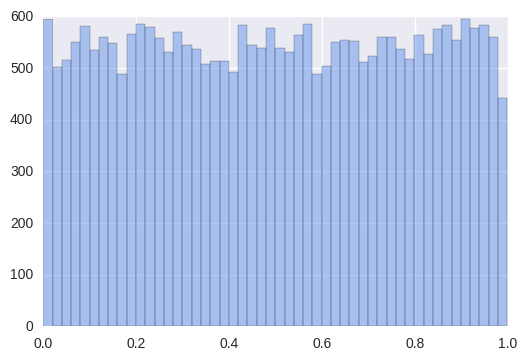

In [67]:
sns.distplot(total_lst, kde=False, rug=False, bins=50,hist_kws={"color":"#6495ED", "alpha":.5})

In [51]:
float(lst)

0.9866666666666667

In [46]:
total_lst

['0.9866666666666667',
 '0.99800796812749',
 '0.9908256880733946',
 '0.9978165938864629',
 '0.9974025974025974',
 '0.9987531172069826',
 '0.9988317757009346',
 '0.9967213114754099',
 '0.9978632478632479',
 '0.9976019184652278',
 '0.9984076433121019',
 '0.9942196531791907',
 '0.9970414201183432',
 '0.9965753424657534',
 '0.9981024667931688',
 '0.9967213114754099',
 '0.9926470588235294',
 '0.9961977186311787',
 '0.9926470588235294',
 '0.9961832061068703',
 '',
 '0.9938650306748467',
 '0.9991489361702127',
 '0.9970238095238095',
 '0.9986754966887417',
 '0.9970501474926253',
 '0.997289972899729',
 '0.9954337899543378',
 '0.9982905982905983',
 '0.9873417721518988',
 '0.9971428571428571',
 '0.9931506849315068',
 '0.996969696969697',
 '0.9955555555555555',
 '0.9846153846153847',
 '0.993006993006993',
 '0.996969696969697',
 '0.9936305732484076',
 '0.9982817869415808',
 '0.9978902953586498',
 '0.9967532467532467',
 '0.9943502824858758',
 '0.9896907216494846',
 '0.9920634920634921',
 '0.99668874

In [40]:
np.nan
lst

nan

In [35]:
type(lst)

float

In [13]:
type(df["frame0_rel"])

pandas.core.series.Series

In [ ]:
print(subSeq)

In [ ]:
find_codons(subSeq,codons=["TAA","TAG","TGA"],frame=6)

In [ ]:
subSeq_lst[2]

In [ ]:
len(cds_lst)

In [ ]:
rec_lst[2].features

In [ ]:
type(rec_lst[0])

In [ ]:
type(rec.features[0].location)

In [ ]:
dir(rec.features[0].location)

In [ ]:
import Bio
help(Bio.SeqFeature)

In [ ]:
seqRec_lst

In [ ]:
feature=rec.features[0]
feature

In [ ]:
subSeq=feature.extract(seqRec_lst[0])

In [ ]:
seqRec=Bio.SeqRecord.SeqRecord("ATGC")

In [ ]:
feature.extract(seqRec)

In [ ]:
seqRec_lst[0].id

In [ ]:
rec_lst[0].id

In [ ]:
type(rec_lst[0])

In [ ]:
rec_lst[0]

In [ ]:
dir(seqRec_lst)

In [ ]:
seqRec_lst[0